#### Reproducable Randomness

In [1]:
import random
random.seed(1)
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.set_random_seed(1)

#### Imports

In [2]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src.datasets import camvid
from src import evaluate
from src import plot
from src import predict
from src import predict_video
from src.tiramisu import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.


#### Metadata

In [3]:
# the location to save coarse training weights to
coarse_weights = 'models/Tiramisu103-CamVid11-coarse.h5'
# the location to save fine training weights to
fine_weights = 'models/Tiramisu103-CamVid11-fine.h5'

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

# Coarse Tuning

In [5]:
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(),
    target_size=target_size,
    crop_size=coarse_crop,
    batch_size=coarse_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


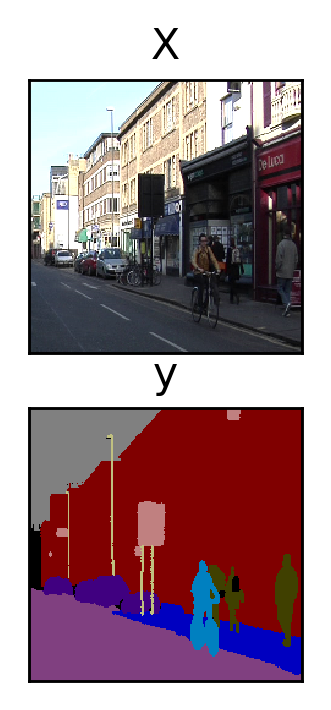

In [6]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = plot.plot(X=X[0], y=y[0], order=['X', 'y'])

In [7]:
# build the model for the image shape and number of labels
model = tiramisu.tiramisu((*coarse_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=100,
        mode='max',
    ),
    LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(coarse_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

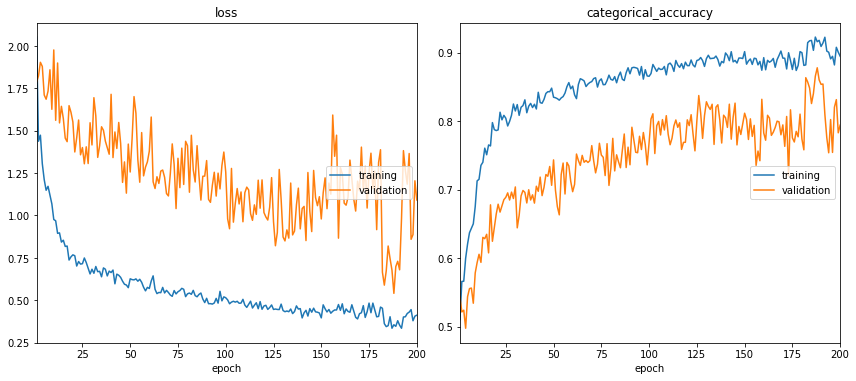

In [9]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [10]:
history_to_results(history)

train       val
categorical_accuracy  0.894533  0.794080
loss                  0.411528  1.091174

## Test Metrics

In [11]:
model.load_weights(coarse_weights)

In [12]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(coarse_weights + '.csv')
metrics

100%|██████████| 233/233 [00:49<00:00,  4.69step/s]


Value
Accuracy                 0.858342
Mean Per Class Accuracy  0.629341
Mean I/U                 0.503476
Bicyclist                0.253628
Building                 0.683816
Car                      0.599531
Column_Pole              0.237419
Fence                    0.232639
Pedestrian               0.298903
Road                     0.893268
Sidewalk                 0.655379
SignSymbol               0.169107
Sky                      0.875890
VegetationMisc           0.638655

In [13]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.858342 |
| Mean Per Class Accuracy | 0.629341 |
| Mean I/U                | 0.503476 |
| Bicyclist               | 0.253628 |
| Building                | 0.683816 |
| Car                     | 0.599531 |
| Column_Pole             | 0.237419 |
| Fence                   | 0.232639 |
| Pedestrian              | 0.298903 |
| Road                    | 0.893268 |
| Sidewalk                | 0.655379 |
| SignSymbol              | 0.169107 |
| Sky                     | 0.87589  |
| VegetationMisc          | 0.638655 |


## Qualitative Results

### Train

In [14]:
X, y, p = predict.predict(model, generators['train'], camvid11)

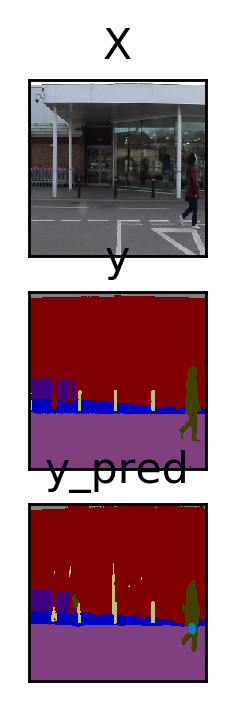

In [15]:
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

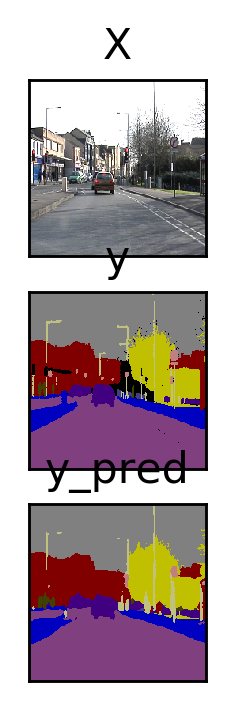

In [16]:
_ = plot.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

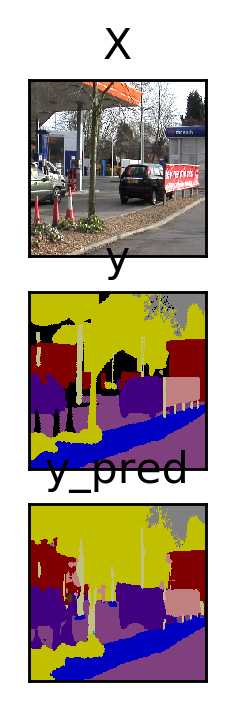

In [17]:
_ = plot.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

### Validation

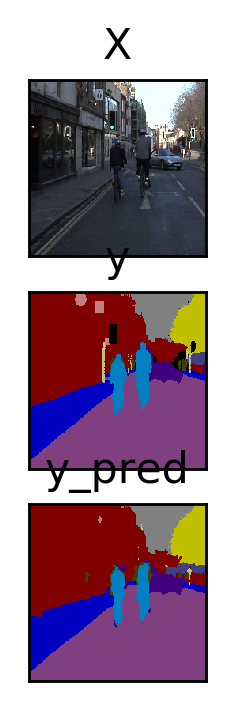

In [18]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

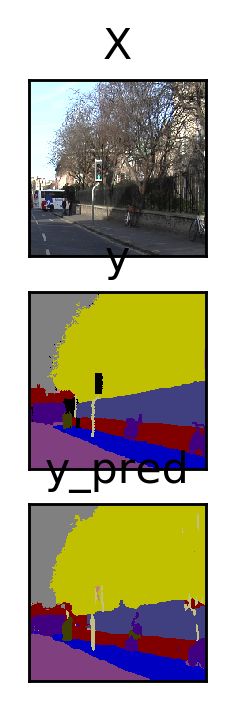

In [19]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

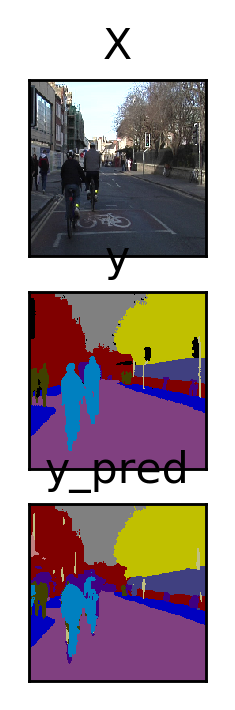

In [20]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

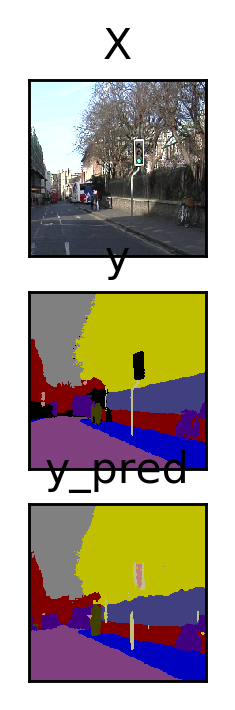

In [21]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

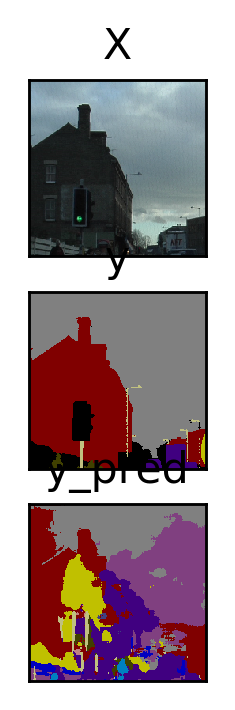

In [22]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

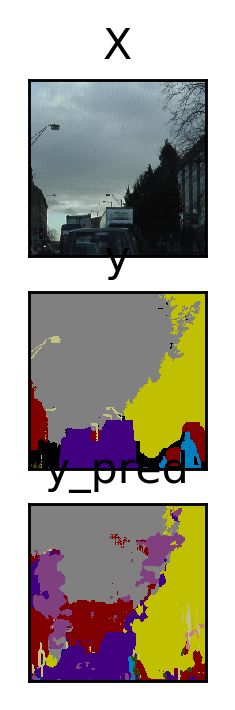

In [23]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

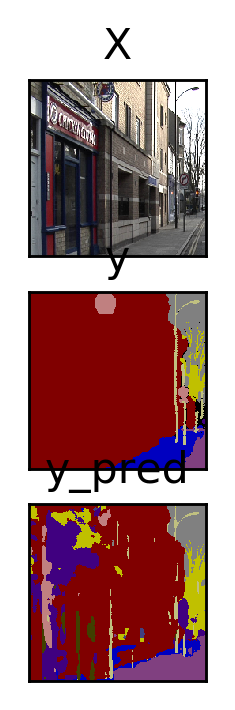

In [24]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

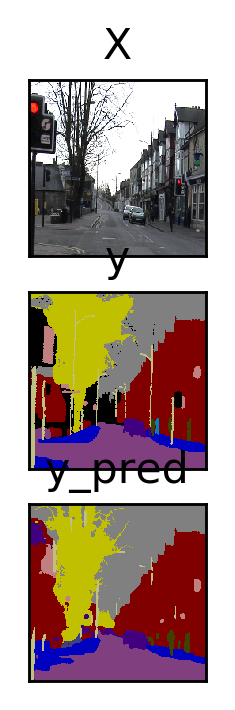

In [25]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

# Clear Session

remove the current model from memory.

In [26]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [27]:
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(),
    target_size=target_size,
    crop_size=fine_crop,
    batch_size=fine_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


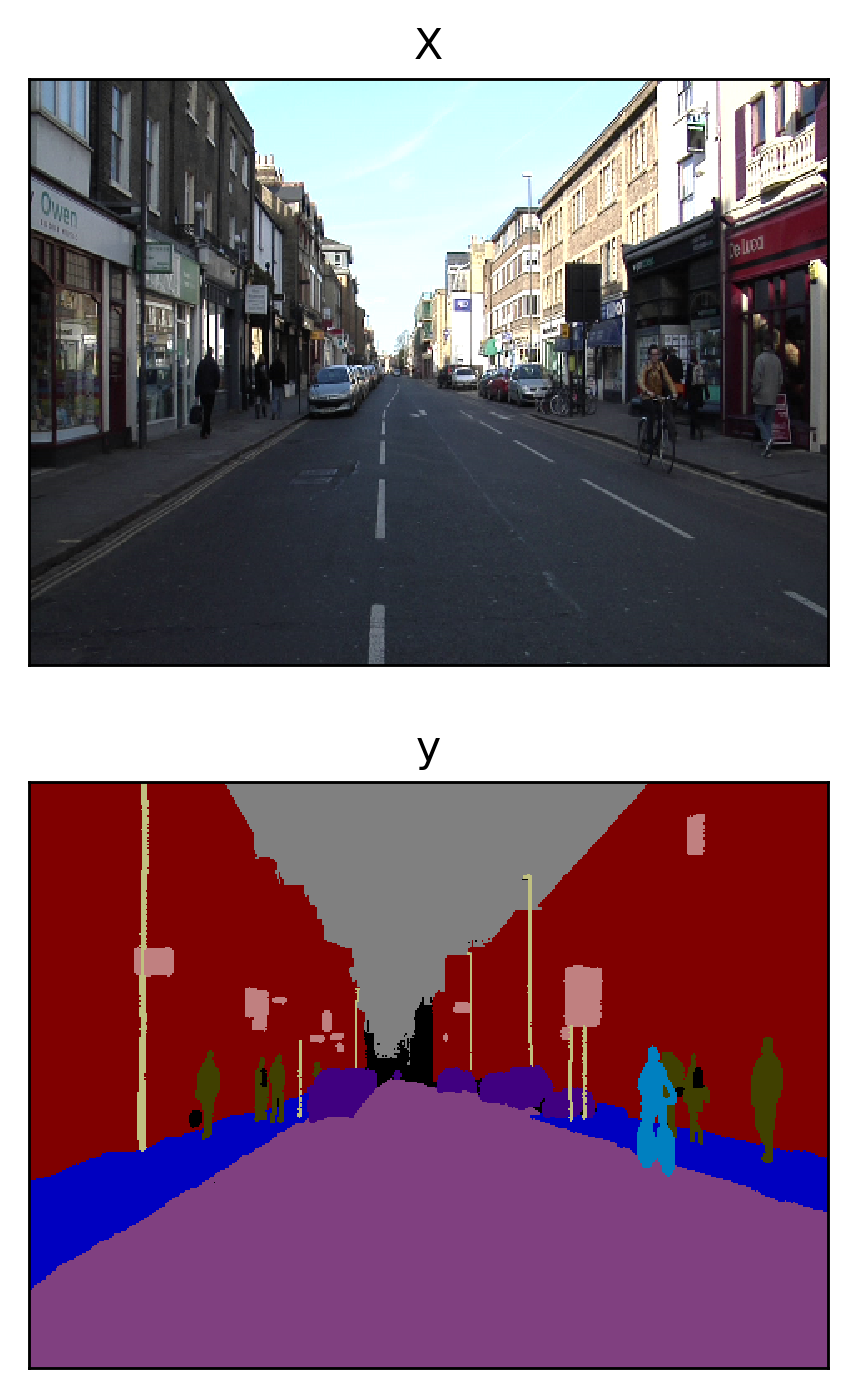

In [28]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = plot.plot(X=X[0], y=y[0], order=['X', 'y'])

In [29]:
# build the model for the image shape and number of labels
tune_model = tiramisu.tiramisu((*fine_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights(coarse_weights)
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=50,
        mode='max',
    ),
    ModelCheckpoint(fine_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

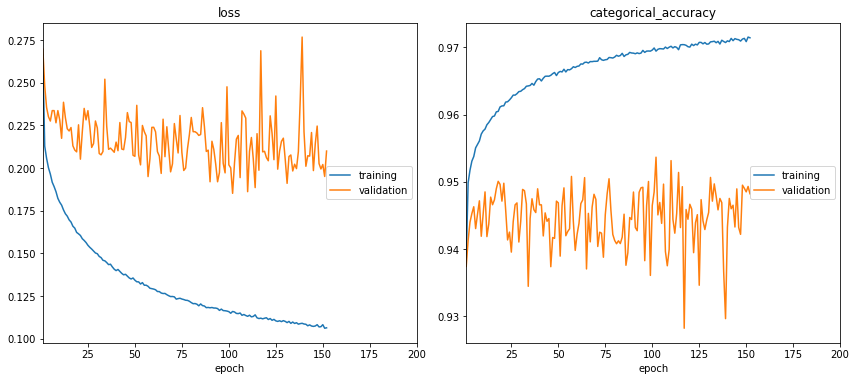

In [31]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [32]:
history_to_results(history)

train       val
categorical_accuracy  0.971429  0.948208
loss                  0.106262  0.209850

## Test Metrics

In [33]:
tune_model.load_weights(fine_weights)

In [34]:
metrics = evaluate.evaluate(tune_model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(fine_weights + '.csv')
metrics

100%|██████████| 233/233 [01:22<00:00,  2.83step/s]


Value
Accuracy                 0.889708
Mean Per Class Accuracy  0.733257
Mean I/U                 0.545109
Bicyclist                0.212223
Building                 0.748671
Car                      0.661334
Column_Pole              0.336555
Fence                    0.246042
Pedestrian               0.310679
Road                     0.907892
Sidewalk                 0.754162
SignSymbol               0.191057
Sky                      0.922928
VegetationMisc           0.704657

In [35]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.889708 |
| Mean Per Class Accuracy | 0.733257 |
| Mean I/U                | 0.545109 |
| Bicyclist               | 0.212223 |
| Building                | 0.748671 |
| Car                     | 0.661334 |
| Column_Pole             | 0.336555 |
| Fence                   | 0.246042 |
| Pedestrian              | 0.310679 |
| Road                    | 0.907892 |
| Sidewalk                | 0.754162 |
| SignSymbol              | 0.191057 |
| Sky                     | 0.922928 |
| VegetationMisc          | 0.704657 |


## Qualitative Results

### Train

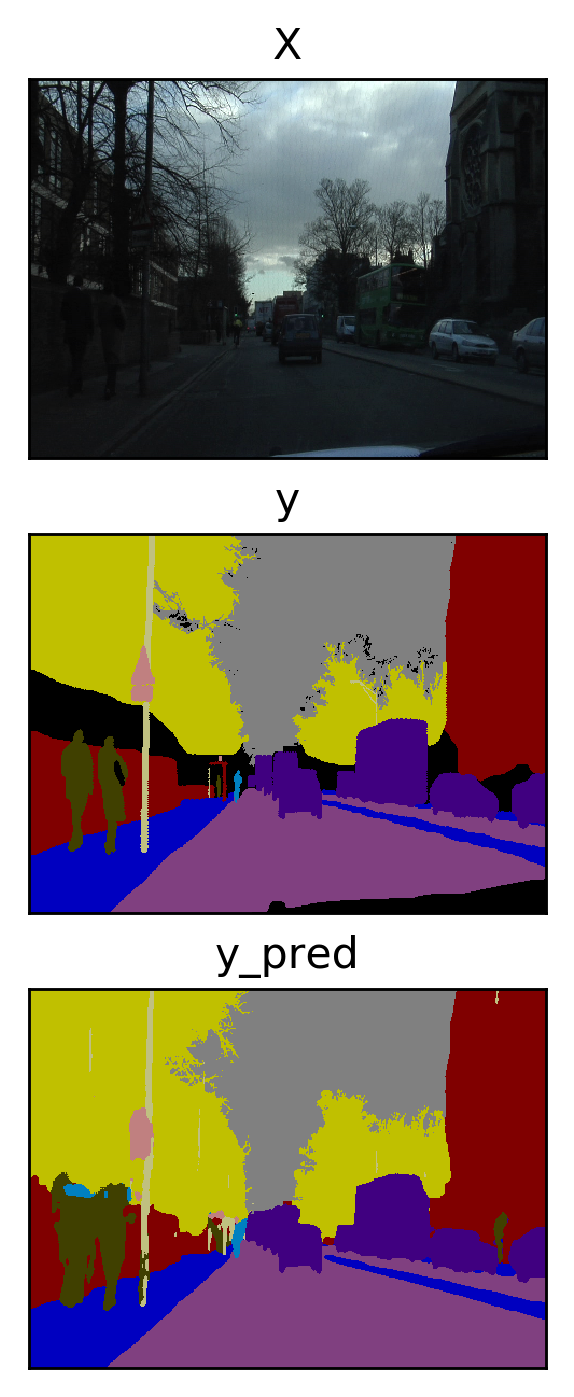

In [36]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

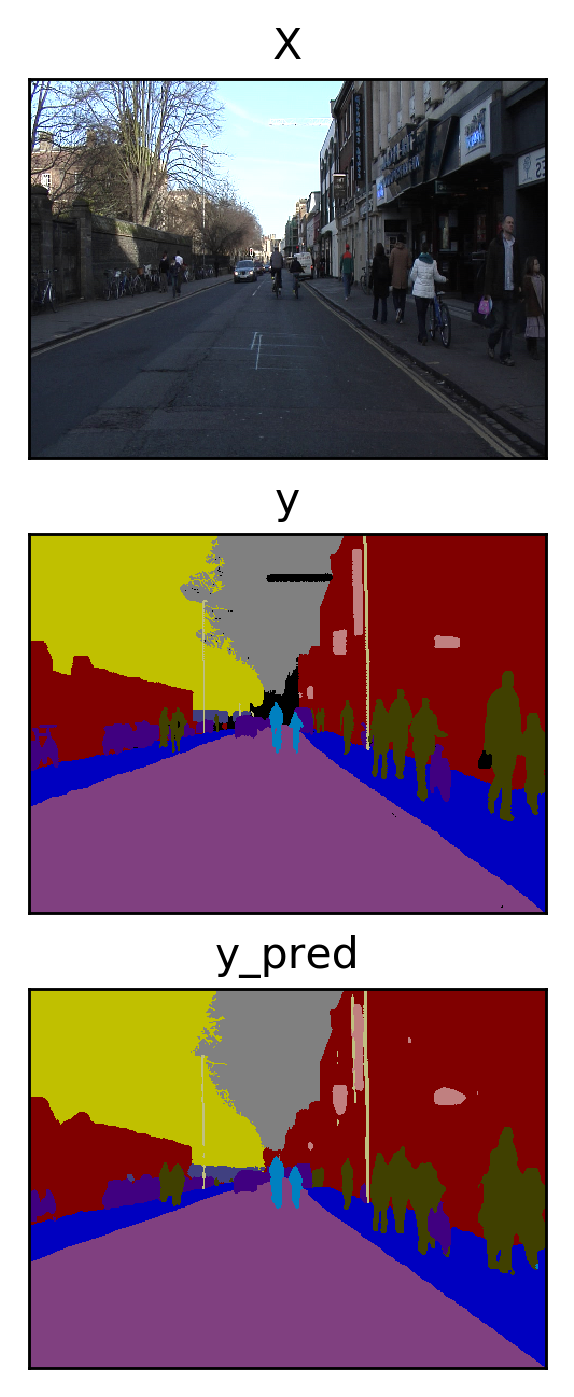

In [37]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

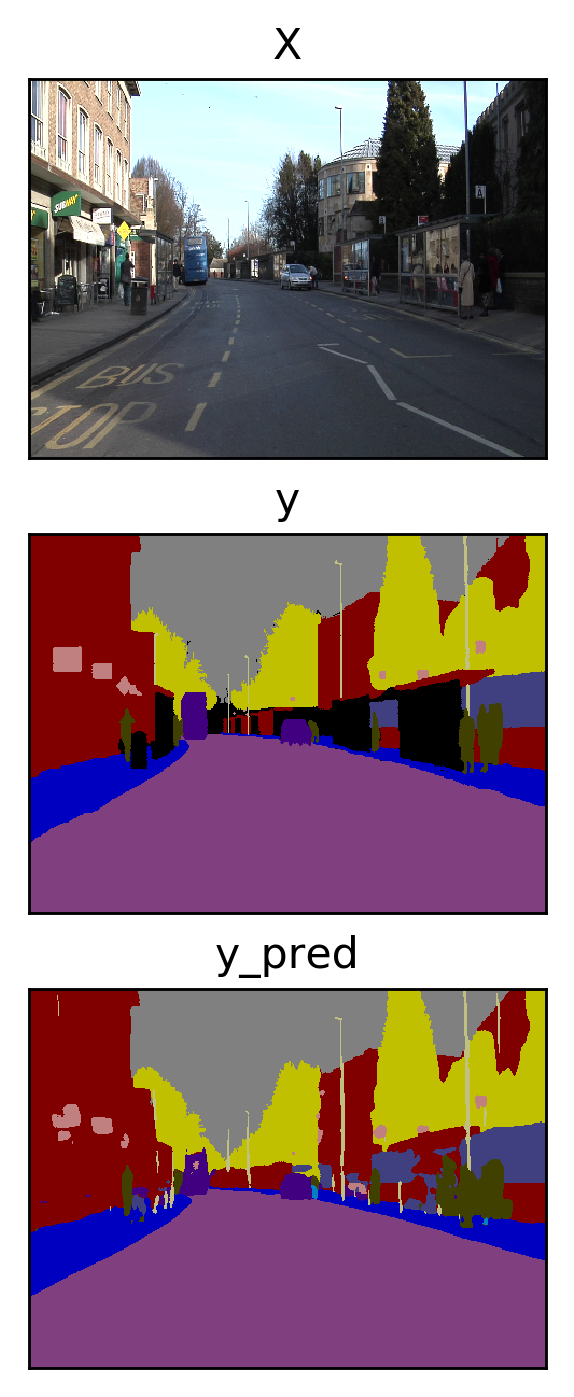

In [38]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

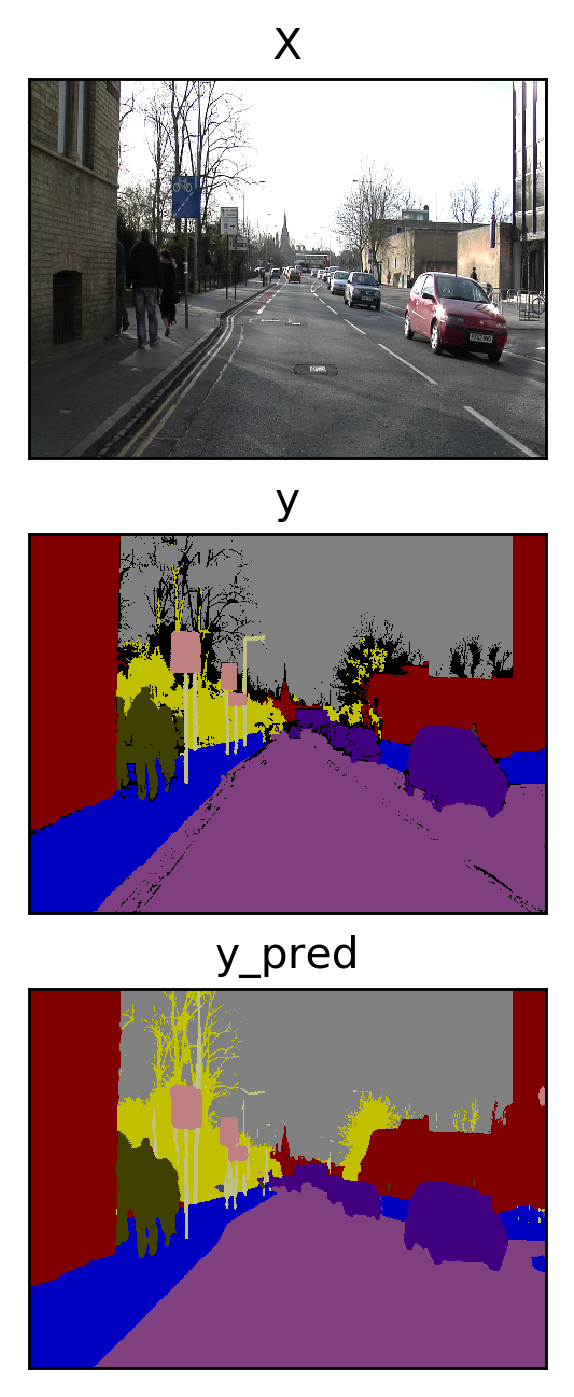

In [39]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Validation

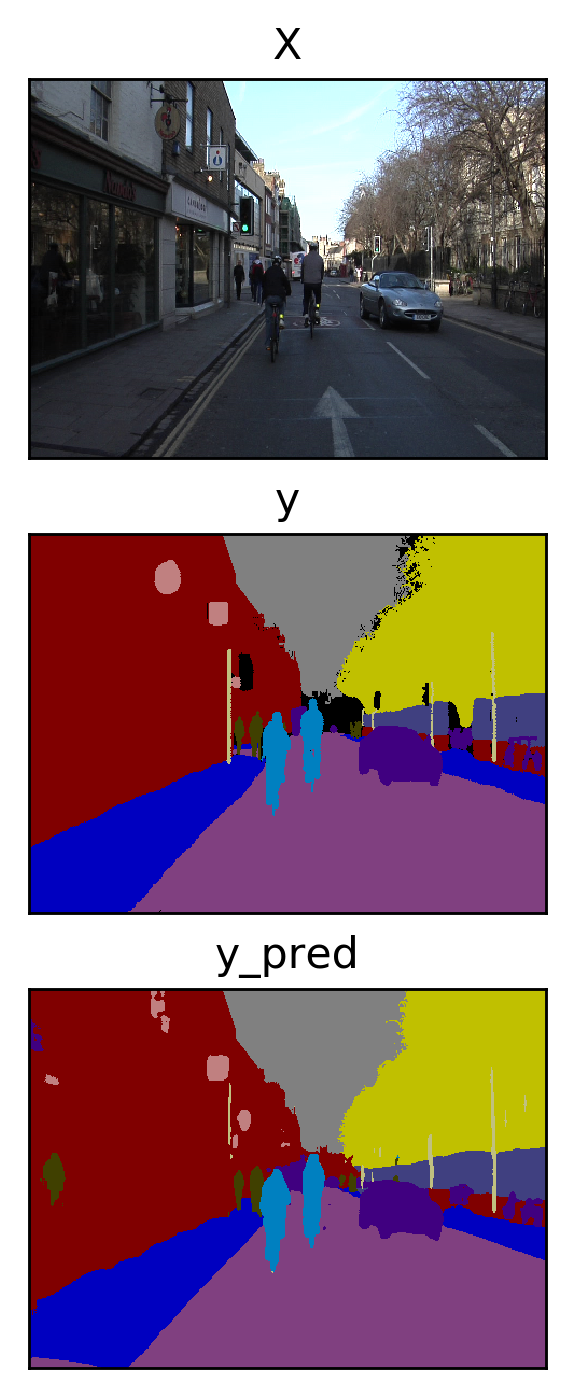

In [40]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

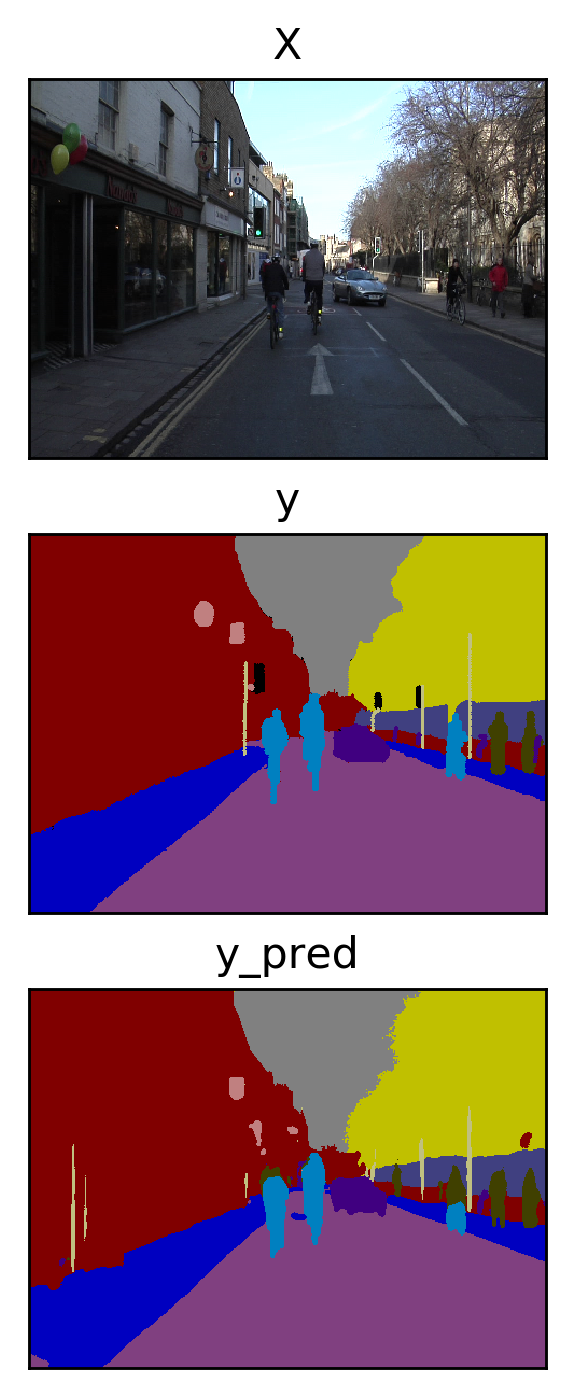

In [41]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

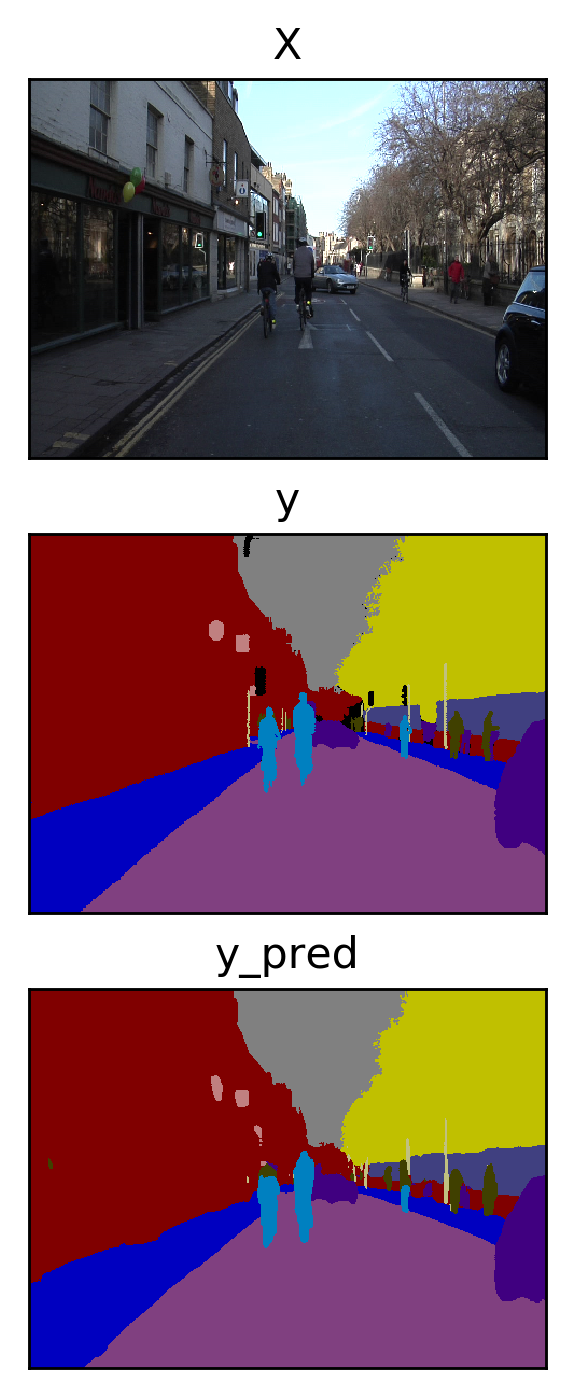

In [42]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

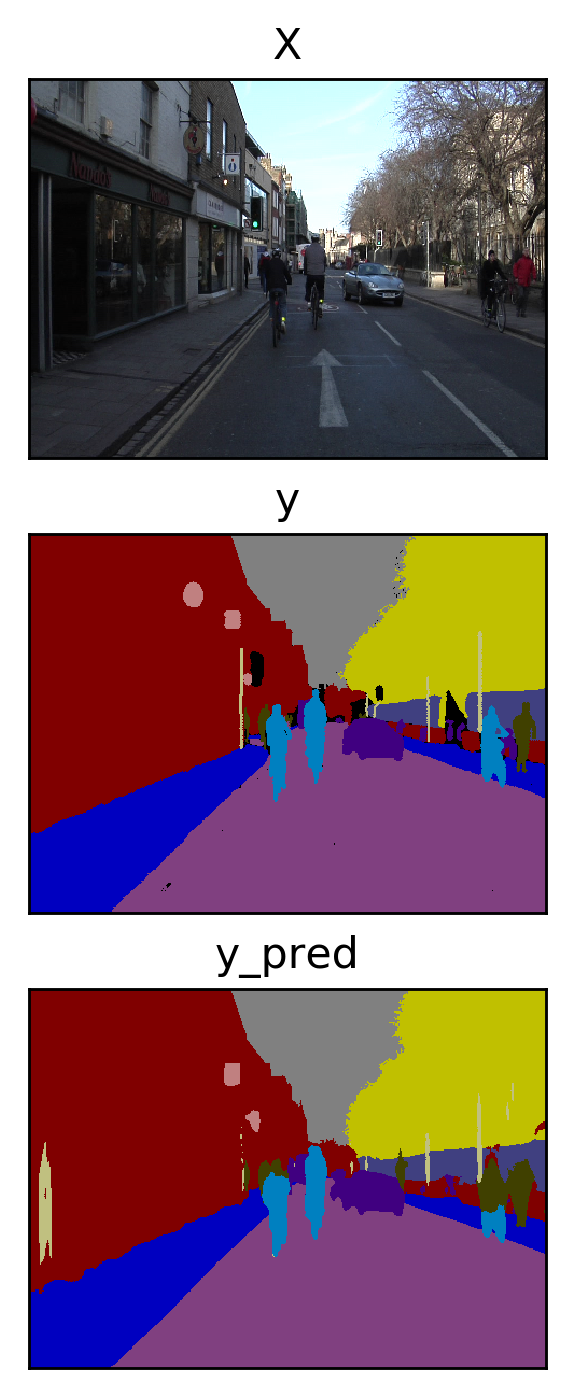

In [43]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

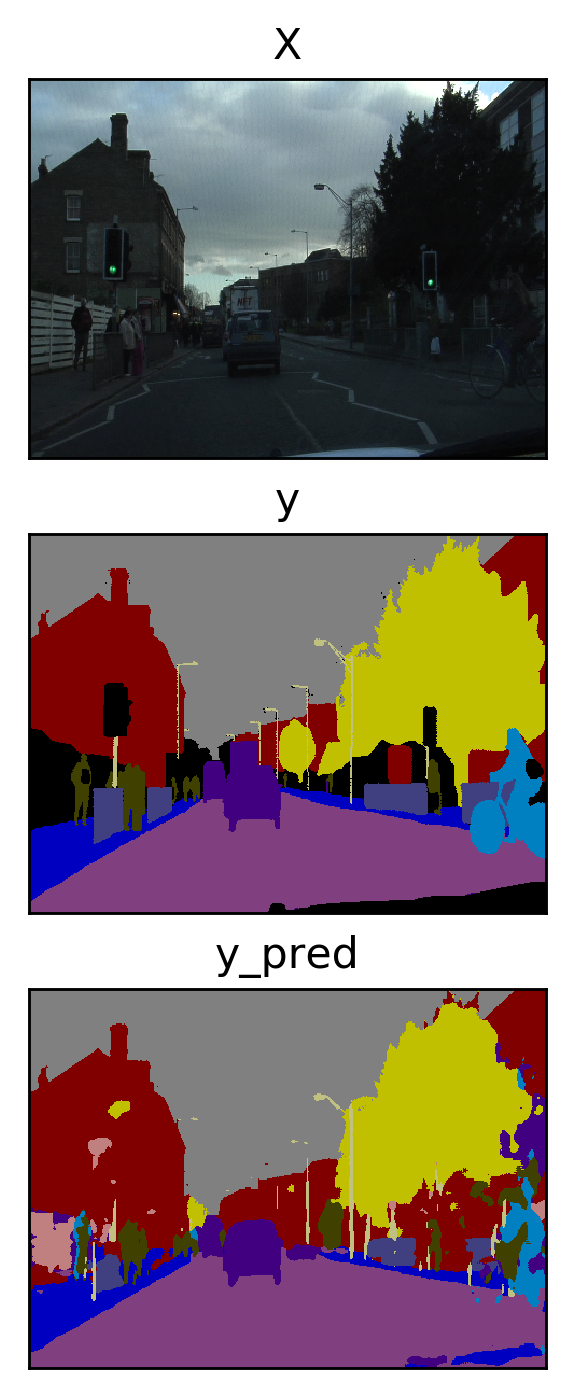

In [44]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/103/0.png', transparent=True, bbox_inches='tight')

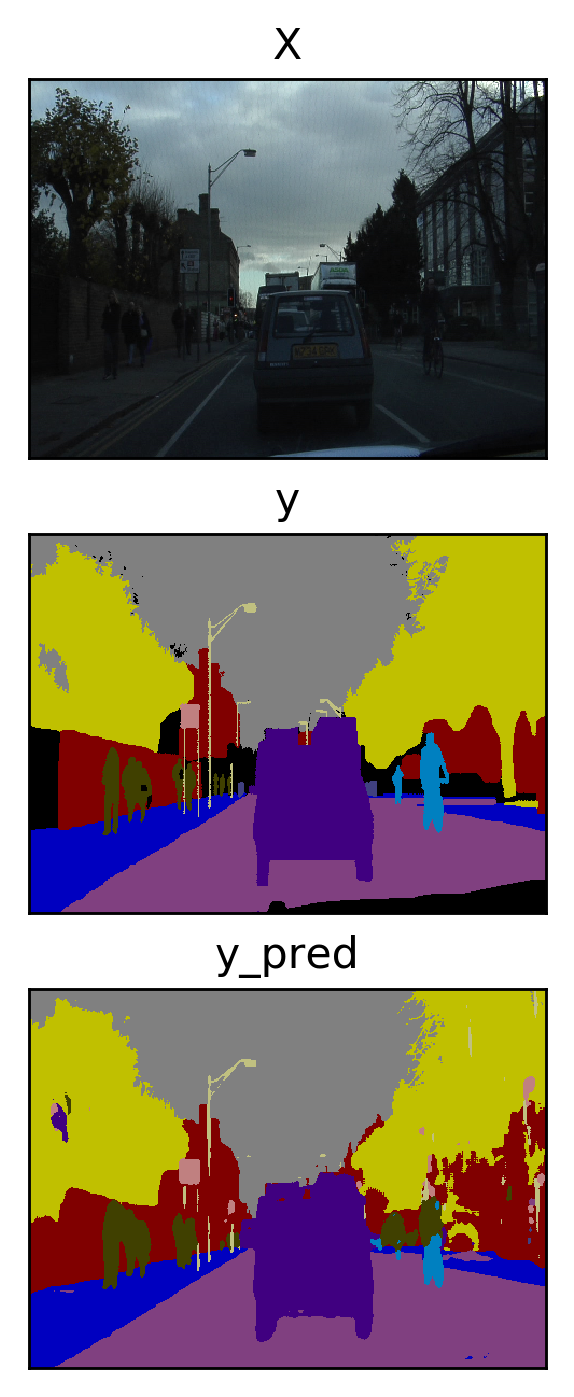

In [45]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/103/1.png', transparent=True, bbox_inches='tight')

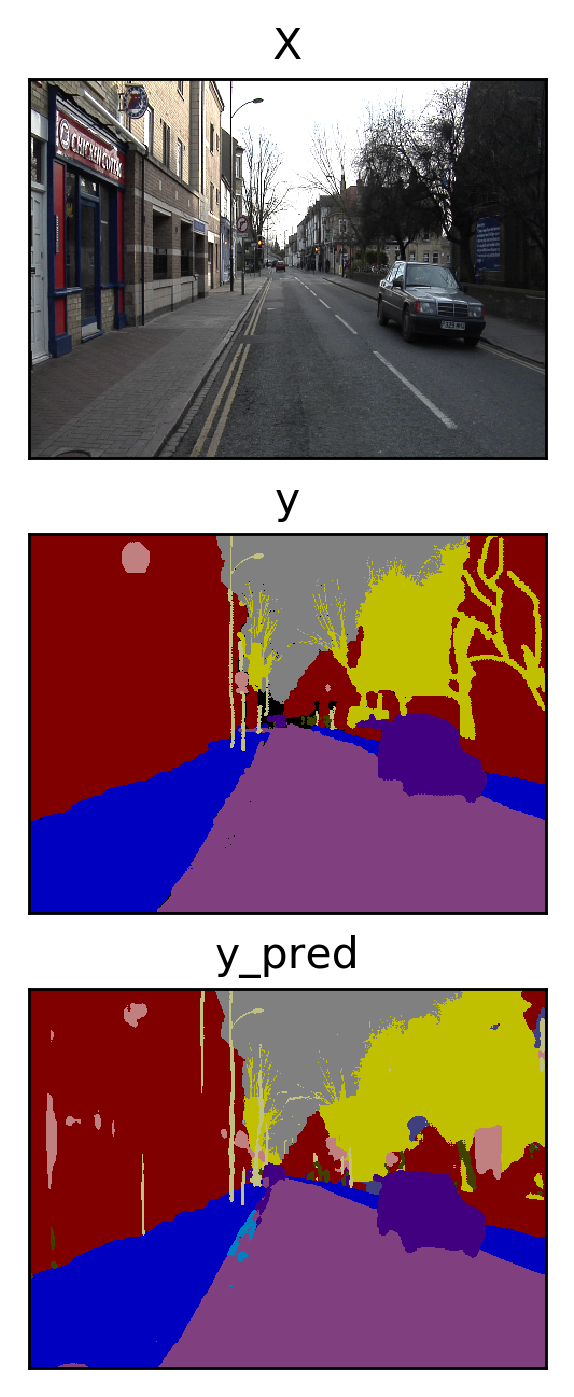

In [46]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/103/2.png', transparent=True, bbox_inches='tight')

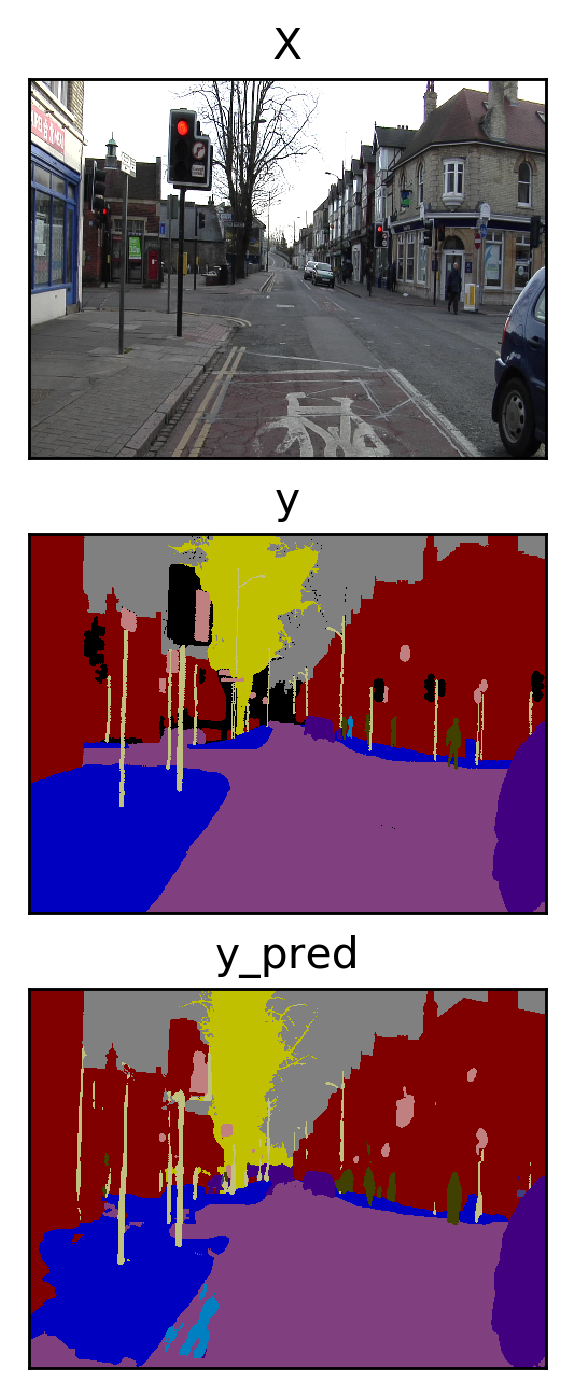

In [47]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/103/3.png', transparent=True, bbox_inches='tight')

# Video

In [48]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/tiramisu/103/{}'.format(video_file)

In [49]:
predict_video.predict_video(video_path, out_path, camvid11, tune_model, predict.predict)

100%|██████████| 6600/6600 [19:50<00:00,  5.55it/s]
